In [ ]:
#!pip install --quiet tqdm

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [354]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm

In [5]:
pwd

'/home/jovyan/capstone-52/topic_modeling_experiments/classifiers'

In [6]:
cd ../../../capstone-52/Pickled_from_mongo/

/home/jovyan/capstone-52/Pickled_from_mongo


In [7]:
df = pd.read_pickle('../Pickled_from_mongo/combined_eg_gulf_200k_sample.p')

In [8]:
df.shape

(192936, 5)

In [9]:
df.head()

,_id,cleaned_geo,cleaned_name,cleaned_text,class
0,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG
1,5a2c7a44204c9e0400cdc0e3,Egypt,agabdelrehim,هي آراء آه بس أزاي أجويرو منتهي يعني أمال لو م...,EG
2,5a2c7a44204c9e0400cdc0e4,None,ElsndubadE,أنت صيني أزاي تقارن شادي بالخطيب ألي هو الوحيد...,EG
3,5a2c7a44204c9e0400cdc0e5,None,h_sawires,أزاي الناس كانت بتغرد في الخمسينات قبل إختراع ...,EG
4,5a2c7a44204c9e0400cdc0e6,Egypt,Hagerelmor,التوينز اللي معاها كل الحلو والوحش والمصايب وا...,EG


### Label Encode the Categories

In [11]:
le = LabelEncoder()
df['class_numerical'] = le.fit_transform(df['class'])

## Ridge Classifier

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['class_numerical'], random_state = 42)

In [18]:
X_train.iloc[6]

'يا جمهور سلطان الدررع والمراكز الاولى نبيها صوتو لسلطان رقم رصيدك'

In [19]:
params = [(ngr, mindf, maxdf, alpha)
          for ngr in [(1,2)]
          for mindf in [1,2,4,8]
          for maxdf in np.linspace(.95,.999,2)
          for alpha in np.logspace(-1,3,2)
         ]

skfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

results_list = []

for ngr, mindf, maxdf, alpha in tqdm(params):
    results = {
        'ngram_range' : ngr,
        'min_df' : mindf,
        'max_df' : maxdf,
        'alpha' : alpha
    }
    train_scores = list()
    val_scores = list()
    
    for train_indices, val_indices in skfold.split(X_train.astype('str'), y_train):
        
        X_train_kf, y_train_kf = X_train.iloc[train_indices], y_train.iloc[train_indices]
        X_val_kf, y_val_kf = X_train.iloc[val_indices], y_train.iloc[val_indices]
        
        ridge_clf_pipe = Pipeline([
                                ('tfidf', TfidfVectorizer(ngram_range=ngr, min_df=mindf, max_df=maxdf)),
                                ('svd', TruncatedSVD(50)),
                                ('clf', RidgeClassifier(alpha=alpha))
                            ])
        
        ridge_clf_pipe.fit(X_train_kf, y_train_kf)
        
        train_scores.append(ridge_clf_pipe.score(X_train_kf, y_train_kf))
        val_scores.append(ridge_clf_pipe.score(X_val_kf, y_val_kf))
        
    results['mean_train_score'] = np.mean(train_scores)
    results['mean_val_score'] = np.mean(val_scores)
    results_list.append(results)

cv_results = pd.DataFrame(results_list)

cv_results.sort_values('mean_val_score', ascending=False, inplace=True)

alpha, maxdf, _, _, mindf, ngr = cv_results.iloc[0].values

cv_results.head()

100%|██████████| 16/16 [08:07<00:00, 30.45s/it]


,alpha,max_df,mean_train_score,mean_val_score,min_df,ngram_range
4,0.1,0.950,0.764606,0.765967,2,"(1, 2)"
10,0.1,0.999,0.762657,0.762374,4,"(1, 2)"
6,0.1,0.999,0.762235,0.761904,2,"(1, 2)"
2,0.1,0.999,0.759146,0.761275,1,"(1, 2)"
0,0.1,0.950,0.757225,0.759561,1,"(1, 2)"


In [ ]:
ridge_clf_pipe = Pipeline([
                        ('tfidf', TfidfVectorizer(ngram_range=ngr, min_df=mindf, max_df=maxdf)),
                        ('svd', TruncatedSVD(100)),
                        ('clf', RidgeClassifier(alpha=alpha))
                    ])

ridge_clf_pipe.fit(X_train, y_train)

In [20]:
ridge_clf_pipe.score(X_train, y_train)

0.75124048043565395

In [21]:
ridge_clf_pipe.score(X_test, y_test)

0.75106771157274954

In [22]:
print(classification_report(y_train, ridge_clf_pipe.predict(X_train)))
print(classification_report(y_test, ridge_clf_pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.82      0.65      0.72     72924
          1       0.70      0.86      0.77     71778

avg / total       0.76      0.75      0.75    144702

             precision    recall  f1-score   support

          0       0.82      0.65      0.72     24328
          1       0.70      0.86      0.77     23906

avg / total       0.76      0.75      0.75     48234



In [53]:
ridge_clf_predictions = ridge_clf_pipe.predict(X_test)

In [24]:
confmat = confusion_matrix(y_test, ridge_clf_predictions)

print(confmat)

[[15746  8582]
 [ 3425 20481]]


In [26]:
fpr, tpr, thresholds = roc_curve(y_train, ridge_clf_pipe.predict(X_train)[:,1])

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

IndexError: too many indices for array

## SGDClassifier

In [54]:
sgd_clf_pipe = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='modified_huber', penalty='l2',
                                           alpha=1e-3, random_state=42)),
                    ])

sgd_clf_pipe.fit(X_train, y_train)  

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...     penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False))])

In [55]:
x_test_pred_proba = sgd_clf_pipe.predict_proba(X_test)

In [150]:
x_test_pred_proba

array([[ 0.74889722,  0.25110278],
       [ 0.7496778 ,  0.2503222 ],
       [ 0.53591916,  0.46408084],
       ..., 
       [ 0.35706785,  0.64293215],
       [ 0.35115204,  0.64884796],
       [ 0.13379524,  0.86620476]])

In [215]:
x_test_pred_proba[:5][:]

array([[ 0.74889722,  0.25110278],
       [ 0.7496778 ,  0.2503222 ],
       [ 0.53591916,  0.46408084],
       [ 0.29060866,  0.70939134],
       [ 0.39606878,  0.60393122]])

In [182]:
X_test_preds_thresh_45 = x_test_pred_proba[:,0] < .45

In [183]:
X_test_preds_thresh_45.sum()

25179

In [184]:
X_test_preds_thresh_45[:5].astype(int)

array([0, 0, 0, 1, 1])

In [57]:
y_test[:5]

45404    0
84725    0
28308    0
50458    1
2451     1
Name: class_numerical, dtype: int64

In [195]:
print(classification_report(y_test, x_test_pred_proba[:,1]>.1))

             precision    recall  f1-score   support

          0       0.99      0.19      0.31     24328
          1       0.55      1.00      0.71     23906

avg / total       0.77      0.59      0.51     48234



In [201]:
print(classification_report(y_test, x_test_pred_proba[:,0]<.33))

             precision    recall  f1-score   support

          0       0.63      0.96      0.76     24328
          1       0.92      0.41      0.57     23906

avg / total       0.77      0.69      0.67     48234



In [202]:
confmat = confusion_matrix(y_test, x_test_pred_proba[:,0]<.33)

print(confmat)

[[23449   879]
 [13992  9914]]


In [311]:
wrong_mask = y_test != (x_test_pred_proba[:,0]<.45).astype(int)

In [332]:
df_misclassified = df.filter(items=(wrong_mask == True), axis=0)

In [333]:
df_misclassified.head()

,_id,cleaned_geo,cleaned_name,cleaned_text,class,class_numerical
False,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG,0
False,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG,0
False,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG,0
False,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG,0
False,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG,0


In [318]:
df_misclassified = df_misclassified.rename_axis('misclassified')

In [319]:
df_misclassified.head()

,_id,cleaned_geo,cleaned_name,cleaned_text,class,class_numerical
misclassified,,,,,,
False,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG,0
False,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG,0
False,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG,0
False,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG,0
False,5a2c7a44204c9e0400cdc0e2,None,kamal,أزاي أقول لك كنا زمان والماضي كان فى الغيب بكر...,EG,0


In [322]:
df_misclassified = df_misclassified.set_index('_id', append=True)

In [212]:
(x_test_pred_proba[:,0]<.45).astype(int)

array([0, 0, 0, ..., 1, 1, 1])

In [167]:
confidence_mask = (x_test_pred_proba[:,0]<.1)|(x_test_pred_proba[:,0]>.6)

In [168]:
confidence_mask.sum()

15402

In [209]:
x_test_pred_proba[confidence_mask, 0]

array([ 0.74889722,  0.7496778 ,  0.92148353, ...,  1.        ,
        0.79732388,  0.68661686])

In [252]:
print(classification_report(y_test[confidence_mask], x_test_pred_proba[confidence_mask,0] < .6))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98     14200
          1       0.95      0.46      0.62      1202

avg / total       0.96      0.96      0.95     15402



In [130]:
confidence_mask

array([False, False, False, ..., False, False,  True], dtype=bool)

In [ ]:
def predict(model, X, threshold):
    proba = model.predict_proba(X)
    return proba[:,0] < threshold

In [39]:
sgd_clf_pipe.score(X_train, y_train)

0.73814460062749654

In [42]:
sgd_clf_pipe.score(X_test, y_test)

0.743521167641083

In [43]:
print(classification_report(y_train, sgd_clf_pipe.predict(X_train)))
print(classification_report(y_test, sgd_clf_pipe.predict(X_test)))

             precision    recall  f1-score   support

          0       0.95      0.51      0.66     72924
          1       0.66      0.97      0.79     71778

avg / total       0.81      0.74      0.72    144702

             precision    recall  f1-score   support

          0       0.93      0.53      0.68     24328
          1       0.67      0.96      0.79     23906

avg / total       0.80      0.74      0.73     48234



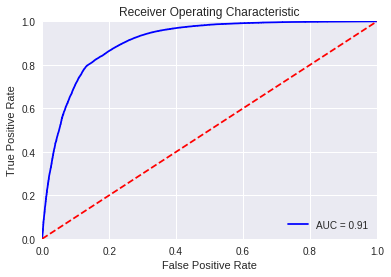

In [357]:
# calculate the fpr and tpr for all thresholds of the classification
probs = x_test_pred_proba
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## MultinomialNB

In [349]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df['cleaned_text'])
X_train_counts.shape

(192936, 223045)

In [46]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(192936, 223045)

In [47]:
multinomialnb_clf = MultinomialNB().fit(X_train_tfidf, df['class'])

In [145]:
 df['class'][:4]

0    EG
1    EG
2    EG
3    EG
Name: class, dtype: object

In [48]:
multinomialnb_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),])

In [49]:
multinomialnb_clf.fit(df['cleaned_text'], df['class'])

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [50]:
print(classification_report(y_train, multinomialnb_clf.predict(X_train)))
print(classification_report(y_test, multinomialnb_clf.predict(X_test)))

ValueError: Mix of label input types (string and number)

In [131]:
from scipy.stats import norm

In [ ]:
norm.pdf()

Automatically created module for IPython interactive environment


ValueError: Found input variables with inconsistent numbers of samples: [192936, 144702]

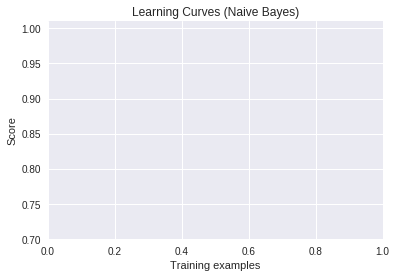

In [346]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X, y = x_test_pred_proba, y_train


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()